In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from tqdm import tqdm
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.grid_search import GridSearch
import time
import csv
import pygame
import itertools
import gc
from scipy import stats

gc.collect();
#from A4_Utils import mode_policy_dict,visualize_policy

In [3]:
base_env = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env)
size_val=290

In [4]:
#Initializing gamms
gammas=np.arange(0.57,1.0,0.03)

### Policy Iteration

In [5]:
#Testing the effect of convergence rate for the same convergence value for blackjack
REPEATS=5
iters=10000
convergence_policy_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
times_policy_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
v_policy_iterations=np.zeros(shape=(len(gammas),REPEATS,size_val))
vi_policy_all_iterations=np.zeros(shape=(len(gammas),REPEATS,iters,size_val))
pi_policy_iteraetions={}

for big_i,gamma in tqdm(enumerate(gammas)):
    for i in range(REPEATS):
        blackjack.reset()
        
        #Solving
        start=time.time()
        V, V_track, pi, convergence_i = Planner(blackjack.P).policy_iteration(gamma=gamma,n_iters=iters)
        end=time.time()

        #Storing Time
        times_policy_iterations[big_i,i]=end-start

        #Getting iterations
        convergence_policy_iterations[big_i,i]=convergence_i

        #Storing policy
        pi_policy_iteraetions['{:.2f}_{}'.format(gamma,i)]=pi

        #Stroing ideal V
        v_policy_iterations[big_i,i]=V

        #Storing V historic
        V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]:]=V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]-1]
        vi_policy_all_iterations[big_i,i]=V_track

0it [00:00, ?it/s]

15it [00:02,  6.06it/s]


In [6]:
#Testing the effect of convergence rate for the same convergence value for frozen lakes
REPEATS=5
iters=10000
convergence_value_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
times_value_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
v_value_iterations=np.zeros(shape=(len(gammas),REPEATS,size_val))
vi_value_all_iterations=np.zeros(shape=(len(gammas),REPEATS,iters,size_val))
pi_value_iteraetions={}

for big_i,gamma in tqdm(enumerate(gammas)):
    for i in range(REPEATS):
        blackjack.reset()
        
        #Solving
        start=time.time()
        V, V_track, pi, convergence_i = Planner(blackjack.P).value_iteration(gamma=gamma,n_iters=iters)
        end=time.time()

        #Storing Time
        times_value_iterations[big_i,i]=end-start

        #Getting iterations
        convergence_value_iterations[big_i,i]=convergence_i

        #Storing policy
        pi_value_iteraetions['{:.2f}_{}'.format(gamma,i)]=pi

        #Stroing ideal V
        v_value_iterations[big_i,i]=V

        #Storing V historic
        V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]:]=V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]-1]
        vi_value_all_iterations[big_i,i]=V_track

15it [00:01,  8.05it/s]


Text(0, 0.5, 'Number of Iterations')

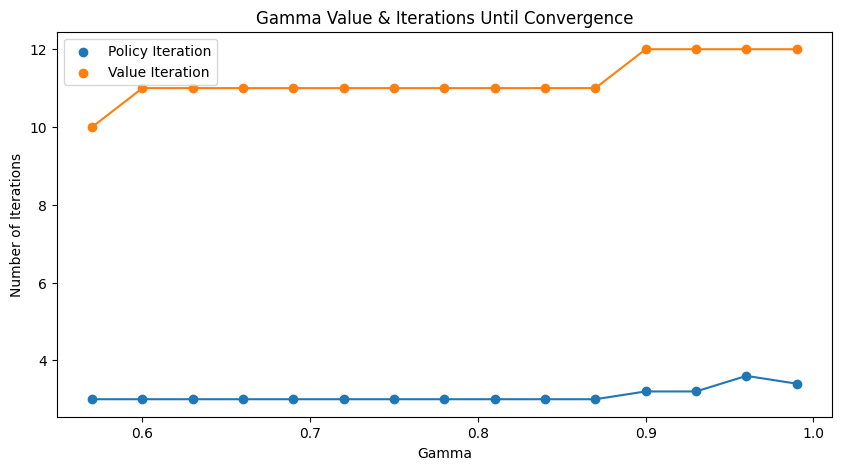

In [7]:
#Plot number of iterations for policy iteration
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Gamma Value & Iterations Until Convergence')
plt.scatter(gammas,convergence_policy_iterations.mean(axis=1),label='Policy Iteration')
plt.scatter(gammas,convergence_value_iterations.mean(axis=1),label='Value Iteration')
plt.plot(gammas,convergence_policy_iterations.mean(axis=1))
plt.plot(gammas,convergence_value_iterations.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Number of Iterations')

Text(0, 0.5, 'Time')

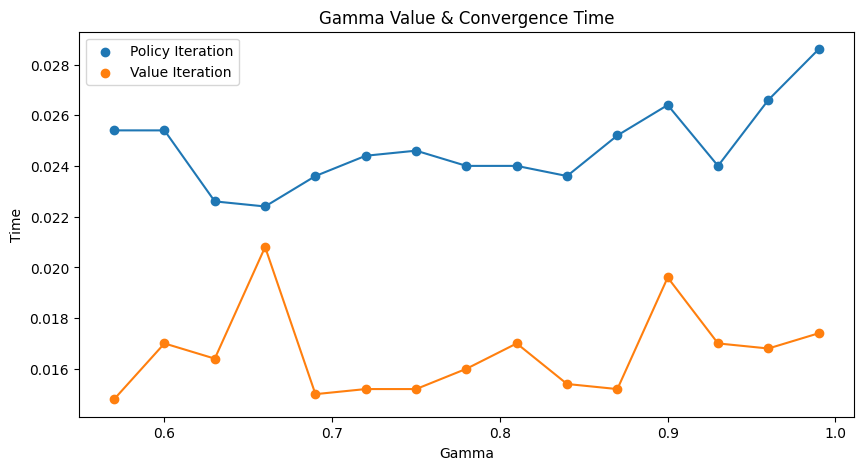

In [8]:
#Plot number Time for Value iteration
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Gamma Value & Convergence Time')
plt.scatter(gammas,times_policy_iterations.mean(axis=1),label='Policy Iteration')
plt.scatter(gammas,times_value_iterations.mean(axis=1),label='Value Iteration')
plt.plot(gammas,times_policy_iterations.mean(axis=1))
plt.plot(gammas,times_value_iterations.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Time')

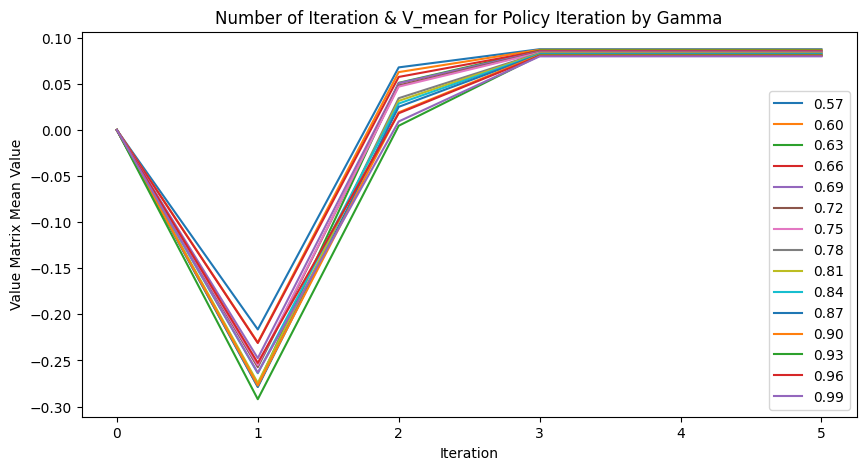

In [9]:
#Plot ting V_mean by gamma for policy iteration
cufoff=6
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Number of Iteration & V_mean for Policy Iteration by Gamma')

for i in range(len(gammas)):
    #plt.scatter(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
    plt.plot(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value Matrix Mean Value');

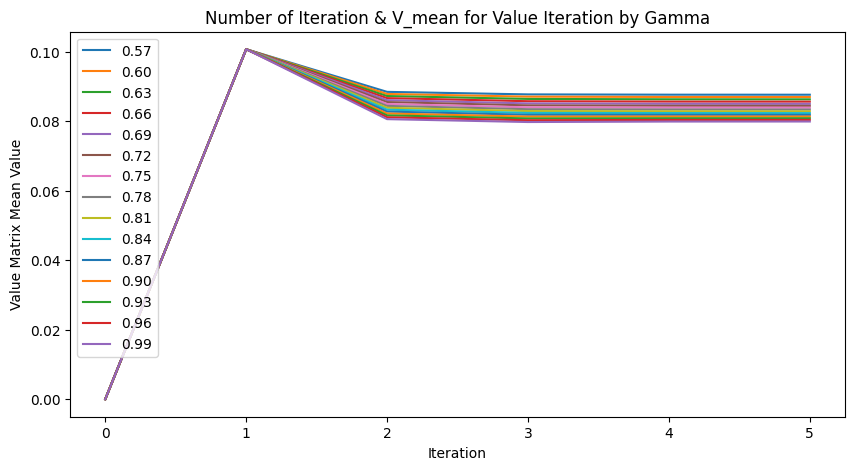

In [10]:
#Plot ting V_mean by gamma for value iteration
cufoff=6
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Number of Iteration & V_mean for Value Iteration by Gamma')

for i in range(len(gammas)):
    #plt.scatter(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
    plt.plot(np.arange(cufoff),vi_value_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value Matrix Mean Value');

In [19]:
#Sucess Rate for each ideal policy for each gamma policy iteration
attempts=1000
win_rate_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
reward_rate_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
num_steps_won_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
parent_dict=pi_policy_iteraetions

for ig,gamma in tqdm(enumerate(gammas)):
    for ir,repeat in enumerate(range(REPEATS)):
        key='{:.2f}_{}'.format(gamma,repeat)
        chosen_dict=parent_dict[key]
        won_counter=0
        reward=0
        steps=0
        for i in range(attempts):
            #Resetting the lake
            blackjack.reset()
            checker=0
            ended=False
            inner_steps=0
            while not ended:
                if checker==0:
                    checker+=1
                    state,r,ended,won,_=blackjack.step(chosen_dict[0])
                else:
                    state,r,ended,won,_=blackjack.step(chosen_dict[state])
                reward+=r
                inner_steps+=1
            if float(r>=1):
                steps+=inner_steps    
            won_counter+=float(r>=1)
        if won_counter==0:
            num_steps_won_policy[ig,ir]=np.inf
        else:
            num_steps_won_policy[ig,ir]=steps/won_counter
        win_rate_policy[ig,ir]=won_counter/attempts
        reward_rate_policy[ig,ir]=reward/attempts

15it [00:04,  3.13it/s]


In [20]:
#Sucess Rate for each ideal policy for each gamma value iteration
attempts=1000
win_rate_value=np.zeros(shape=(gammas.shape[0],REPEATS))
reward_rate_value=np.zeros(shape=(gammas.shape[0],REPEATS))
parenta_dict=pi_value_iteraetions
num_steps_won_value=np.zeros(shape=(gammas.shape[0],REPEATS))

for ig,gamma in tqdm(enumerate(gammas)):
    for ir,repeat in enumerate(range(REPEATS)):
        key='{:.2f}_{}'.format(gamma,repeat)
        chosen_dict=parent_dict[key]
        won_counter=0
        reward=0
        steps=0
        for i in range(attempts):
            #Resetting the lake
            blackjack.reset()
            checker=0
            ended=False
            inner_steps=0
            while not ended:
                if checker==0:
                    checker+=1
                    state,r,ended,won,_=blackjack.step(chosen_dict[0])
                else:
                    state,r,ended,won,_=blackjack.step(chosen_dict[state])
                reward+=r
                inner_steps+=1
            if float(r>=1):
                steps+=inner_steps    
            won_counter+=float(r>=1)
        if won_counter==0:
            num_steps_won_value[ig,ir]=np.inf
        else:
            num_steps_won_value[ig,ir]=steps/won_counter
        win_rate_value[ig,ir]=won_counter/attempts
        reward_rate_value[ig,ir]=reward/attempts

0it [00:00, ?it/s]

15it [00:04,  3.16it/s]


Text(0, 0.5, 'Average Number of Steps for Win')

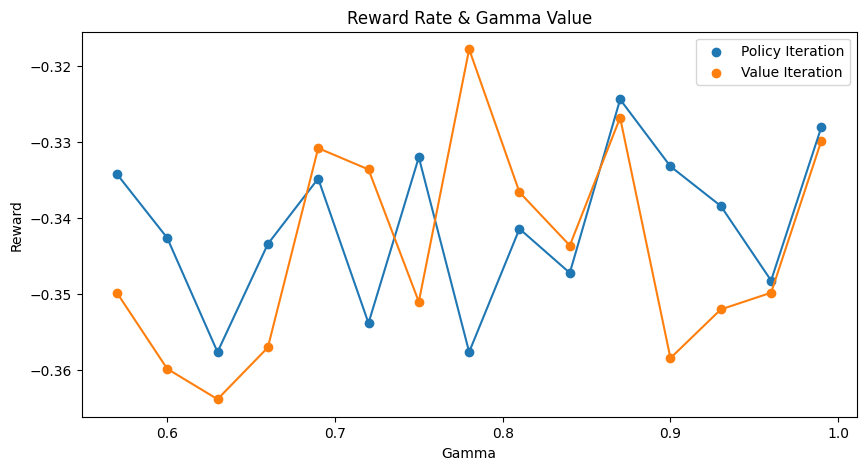

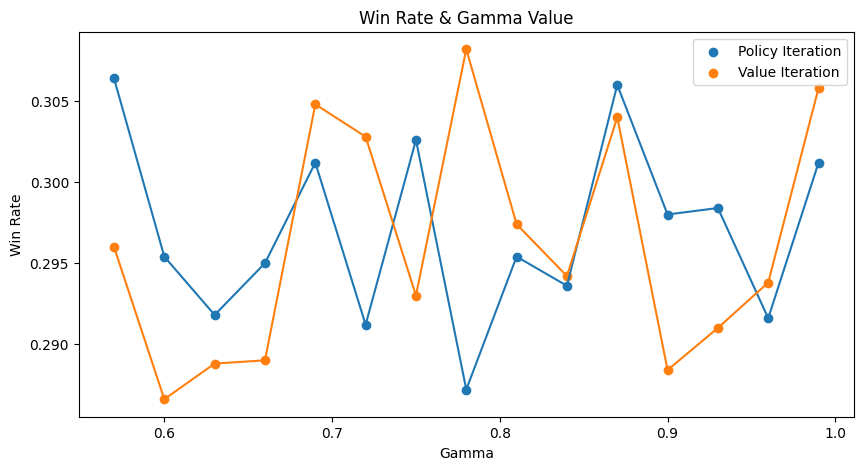

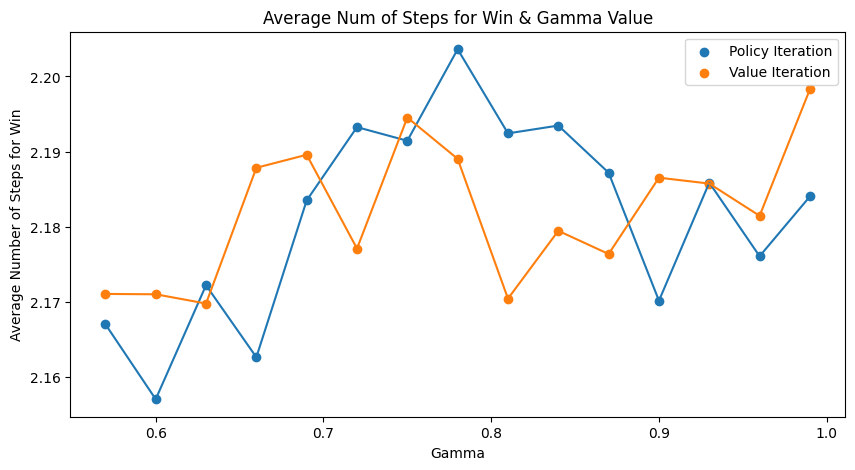

In [21]:
#Plotting win rate, average score and number of steps
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Reward Rate & Gamma Value')
plt.scatter(gammas,reward_rate_policy.mean(axis=1),label='Policy Iteration')
plt.scatter(gammas,reward_rate_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,reward_rate_policy.mean(axis=1))
plt.plot(gammas,reward_rate_value.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Reward')

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Win Rate & Gamma Value')
plt.scatter(gammas,win_rate_policy.mean(axis=1),label='Policy Iteration')
plt.scatter(gammas,win_rate_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,win_rate_policy.mean(axis=1))
plt.plot(gammas,win_rate_value.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Win Rate')

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Average Num of Steps for Win & Gamma Value')
plt.scatter(gammas,num_steps_won_policy.mean(axis=1),label='Policy Iteration')
plt.scatter(gammas,num_steps_won_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,num_steps_won_policy.mean(axis=1))
plt.plot(gammas,num_steps_won_value.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Average Number of Steps for Win')